# Iris Species Preliminary Analysis

In [ ]:
! pip install opendp

   ---------------------------------------- 0.0/22.3 MB ? eta -:--:--
   ---- ----------------------------------- 2.6/22.3 MB 13.8 MB/s eta 0:00:02
   --------- ------------------------------ 5.2/22.3 MB 13.3 MB/s eta 0:00:02
   -------------- ------------------------- 8.1/22.3 MB 14.0 MB/s eta 0:00:02
   -------------------- ------------------- 11.5/22.3 MB 14.4 MB/s eta 0:00:01
   ------------------------ --------------- 13.6/22.3 MB 14.3 MB/s eta 0:00:01
   ------------------------------ --------- 17.0/22.3 MB 13.9 MB/s eta 0:00:01
   ------------------------------------ --- 20.2/22.3 MB 14.2 MB/s eta 0:00:01
   ---------------------------------------- 22.3/22.3 MB 13.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from opendp.mod import enable_features
from opendp.measurements import make_laplace
from opendp.domains import atom_domain
from opendp.metrics import absolute_distance
enable_features("contrib")

In [12]:
df_iris = pd.read_csv('../data/Iris.csv')
df_iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
# Selecting values for epsilon
# Low ε (e.g., 0.1, 0.5) → More noise, stronger privacy, but lower accuracy.
# High ε (e.g., 5, 10) → Less noise, higher accuracy, but weaker privacy.

sepal_width = df_iris["SepalWidthCm"].to_numpy()
sepal_length = df_iris["SepalLengthCm"].to_numpy()
delta_1 = np.max(np.abs(np.diff(np.sort(sepal_width))))  


epsilon_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
results = {}

In [22]:
for epsilon in epsilon_values:
    scale = delta_1 / epsilon
    laplace_mechanism = make_laplace(
        input_domain=atom_domain(T=float),
        input_metric=absolute_distance(T=float),
        scale=scale
    )
    dp_samples = np.array([[laplace_mechanism(x) for x in sepal_width] for _ in range(10)])
    dp_sepal_width = np.mean(dp_samples, axis=0)
    mae = np.mean(np.abs(dp_sepal_width - sepal_width))
    stability = np.mean(np.std(dp_samples, axis=0))  
    noise_variance = np.var(dp_samples - sepal_width, axis=0).mean()
    emd = wasserstein_distance(sepal_width, dp_sepal_width)
    results[epsilon] = {"dp_values": dp_sepal_width, "mae": mae, "emd": emd, "stability": stability,
        "noise_variance": noise_variance}

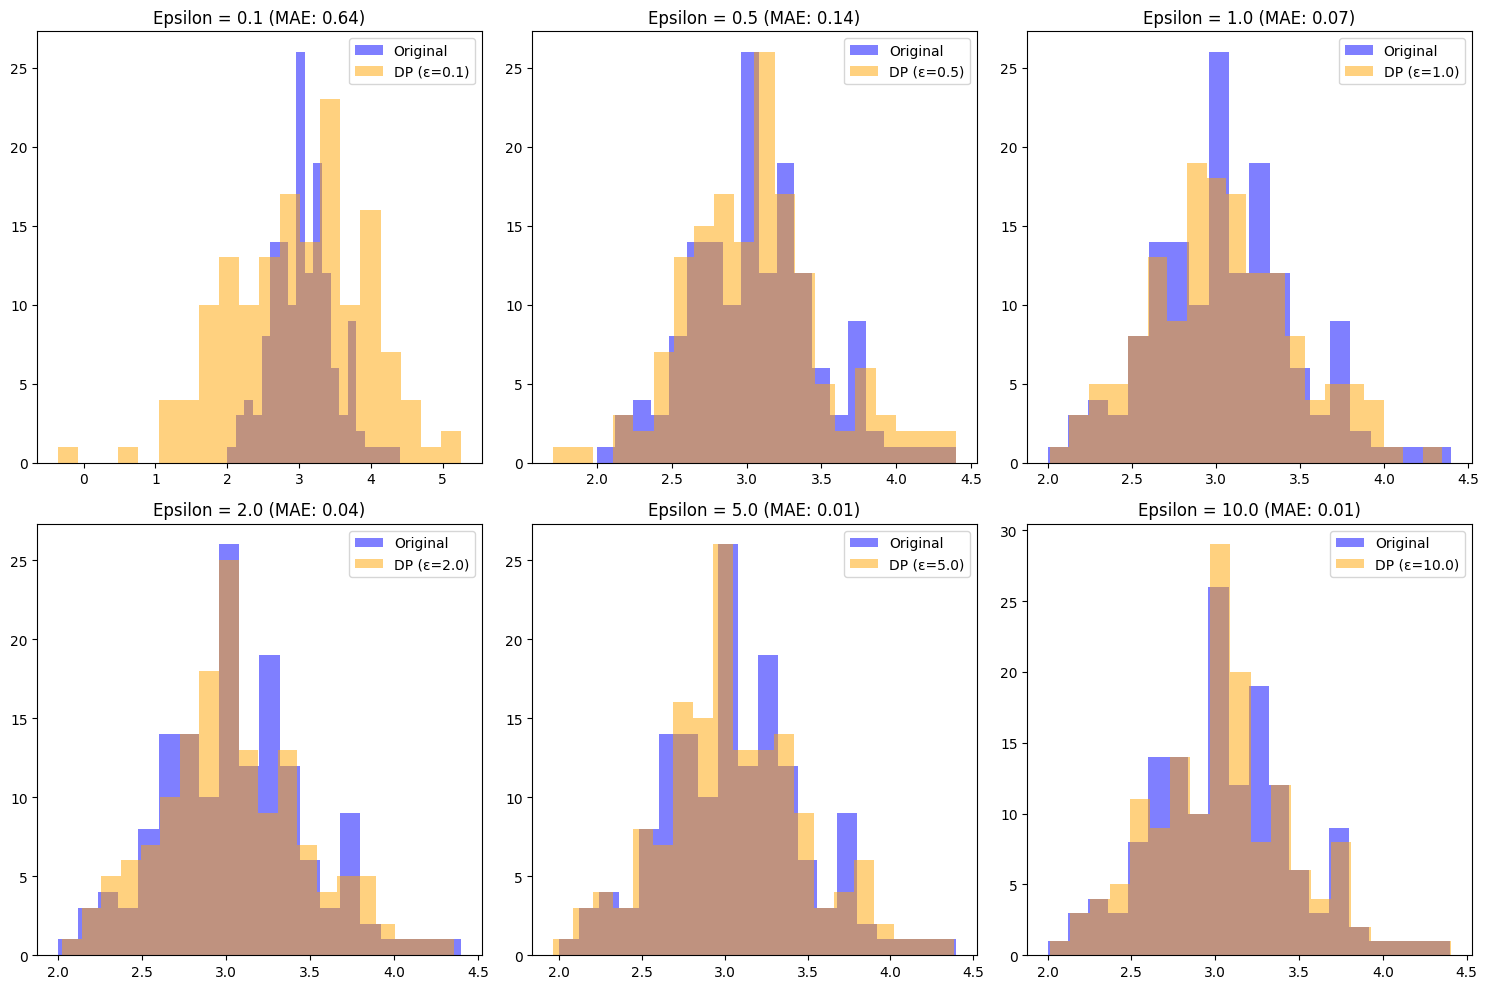

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (epsilon, data) in enumerate(results.items()):
    ax = axes[i]
    ax.hist(sepal_width, bins=20, alpha=0.5, label="Original", color='blue')
    ax.hist(data["dp_values"], bins=20, alpha=0.5, label=f"DP (ε={epsilon})", color='orange')
    ax.set_title(f"Epsilon = {epsilon} (MAE: {data['mae']:.2f})")
    ax.legend()

plt.tight_layout()
plt.show()

In [24]:
# metric to measure accuracy
print("\nPrivacy and Utility Metrics:")
print("---------------------------------------------------------")
print(f"{'Epsilon':<10}{'MAE':<10}{'EMD':<10}{'Stability':<12}{'Noise Variance':<15}")
print("---------------------------------------------------------")
for epsilon, data in results.items():
    print(f"{epsilon:<10}{data['mae']:.3f}     {data['emd']:.3f}     {data['stability']:.4f}       {data['noise_variance']:.4f}")


Privacy and Utility Metrics:
---------------------------------------------------------
Epsilon   MAE       EMD       Stability   Noise Variance 
---------------------------------------------------------
0.1       0.639     0.423     2.5000       6.9466
0.5       0.136     0.047     0.5041       0.2870
1.0       0.071     0.034     0.2543       0.0717
2.0       0.038     0.030     0.1260       0.0177
5.0       0.012     0.012     0.0517       0.0030
10.0      0.006     0.006     0.0249       0.0007


### Optimal Epsilon Value

In [26]:
epsilons = list(results.keys())
maes = [results[eps]["mae"] for eps in epsilons]
emds = [results[eps]["emd"] for eps in epsilons]
stabilities = [results[eps]["stability"] for eps in epsilons]
noise_variances = [results[eps]["noise_variance"] for eps in epsilons]

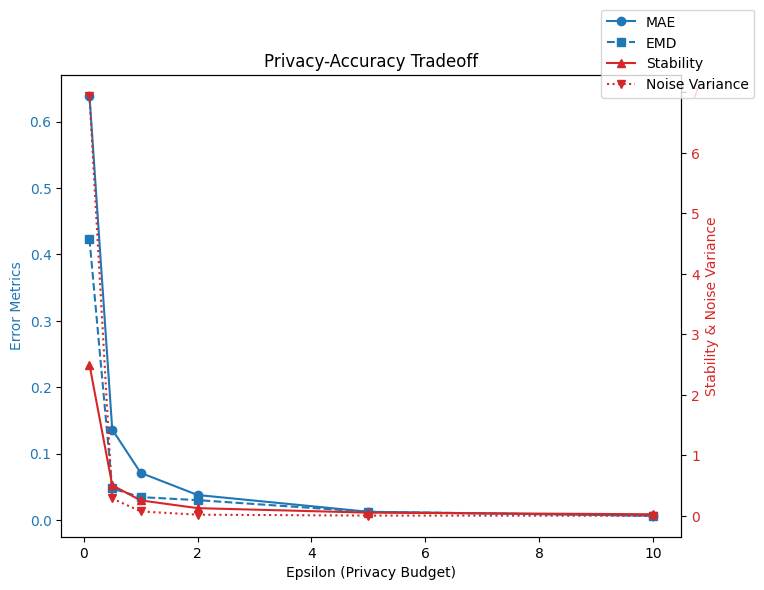

In [27]:
fig, ax1 = plt.subplots(figsize=(8,6))

ax1.set_xlabel("Epsilon (Privacy Budget)")
ax1.set_ylabel("Error Metrics", color="tab:blue")
ax1.plot(epsilons, maes, label="MAE", marker="o", color="tab:blue")
ax1.plot(epsilons, emds, label="EMD", marker="s", linestyle="dashed", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Stability & Noise Variance", color="tab:red")
ax2.plot(epsilons, stabilities, label="Stability", marker="^", color="tab:red")
ax2.plot(epsilons, noise_variances, label="Noise Variance", marker="v", linestyle="dotted", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

fig.legend(loc="upper right", bbox_to_anchor=(1,1))
plt.title("Privacy-Accuracy Tradeoff")
plt.show()